In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [35]:
df = pd.read_csv('merged_car_sales_with_features.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DAIHATSU                   54 non-null     float64
 1   HONDA                      54 non-null     float64
 2   MITSUBISHI                 54 non-null     float64
 3   SUZUKI                     54 non-null     float64
 4   TOYOTA                     54 non-null     float64
 5   bi_policy_rate_pct         54 non-null     object 
 6   inflation_yoy_pct          54 non-null     object 
 7   consumer_confidence_index  54 non-null     object 
 8   is_lebaran_season          54 non-null     int64  
 9   is_giias_month             54 non-null     int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 4.6+ KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA  \
count     54.000000     54.000000     54.000000     54.000000   

In [36]:
df_extra = pd.read_csv('extra_feature_engineering_withGeminii.csv',delimiter=';')

df_extra.info()
print(df_extra.describe())
print(df_extra.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   waktu                      56 non-null     object
 1   bi_policy_rate_pct         56 non-null     object
 2   inflation_yoy_pct          56 non-null     object
 3   consumer_confidence_index  56 non-null     object
 4   is_lebaran_season          56 non-null     int64 
 5   is_giias_month             56 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 2.8+ KB
       is_lebaran_season  is_giias_month
count          56.000000       56.000000
mean            0.178571        0.107143
std             0.386459        0.312094
min             0.000000        0.000000
25%             0.000000        0.000000
50%             0.000000        0.000000
75%             0.000000        0.000000
max             1.000000        1.000000
            waktu bi_policy_rate_pct in

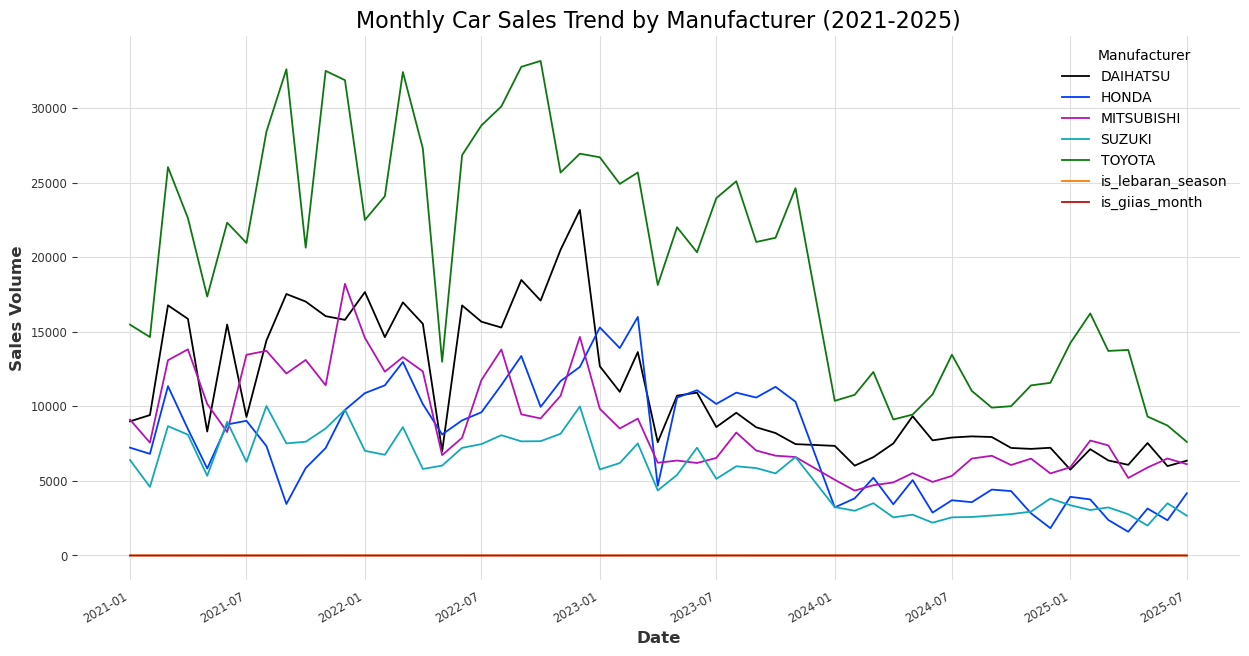

In [37]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [38]:
# # Calculate total sales to use as the target variable
# df['TOTAL_SALES'] = df.sum(axis=1)

# def create_features(df):
#     """Function to create time-series features from a datetime index."""
#     df['year'] = df.index.year
#     df['month'] = df.index.month
#     df['quarter'] = df.index.quarter
#     df['dayofyear'] = df.index.dayofyear
#     df['weekofyear'] = df.index.isocalendar().week.astype(int)

#     return df

# df = create_features(df)

# # Define features and the target
# FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
# TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

# for brand in TARGETS:
#     df[f'{brand}_lag1'] = df[brand].shift(1)
#     df[f'{brand}_lag3'] = df[brand].shift(3)
#     # df[f'{brand}_lag12'] = df[brand].shift(12)
    
#     # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
#     df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
#     # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
#     # 移動標準偏差 (過去3ヶ月)
#     df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
# df = df.dropna()

# X = df[FEATURES]
# y = df[TARGETS]



# print(df.head(20))


In [39]:
# --- 必要なライブラリとモデルのインポート ---
import pandas as pd
from darts import TimeSeries
from darts.metrics import smape

# 試したいモデルをDartsからインポート
from darts.models import (
    ARIMA,AutoARIMA,
    ExponentialSmoothing,
    Theta,
    FFT # Fast Fourier Transform
)

# --- 1. データの準備 (以前と同様) ---
target_brand = 'SUZUKI'
series = TimeSeries.from_series(df[target_brand], freq='MS')
train, val = series.split_before(pd.Timestamp('20250101'))


# --- 2. 試したいモデルのリストを作成 ---
# モデルの名前と、インスタンス化したモデルを辞書として定義
models_to_try = {
    # "ARIMA": ARIMA(),
    "AutoARIMA": AutoARIMA(seasonal=True,             # 12ヶ月の季節性を考慮
        stepwise=True),
    "ExponentialSmoothing": ExponentialSmoothing(),
    "Theta": Theta(),
    "FFT": FFT()
}


# --- 3. ループですべてのモデルを学習・評価 ---
print("Evaluating various models...")
results = []

for model_name, model in models_to_try.items():
    try:
        # モデルの学習
        model.fit(train)
        
        # 予測の実行
        prediction = model.predict(len(val))
        
        # SMAPEの計算
        smape_score = smape(val, prediction)
        
        # 結果を保存
        results.append({
            "Model": model_name,
            "SMAPE (%)": smape_score
        })
        
        print(f"  - {model_name} SMAPE: {smape_score:.2f}%")
        
    except Exception as e:
        # モデルがエラーになった場合
        print(f"  - {model_name} failed with error: {e}")
        results.append({
            "Model": model_name,
            "SMAPE (%)": None
        })


# --- 4. 結果を比較する ---
df_results = pd.DataFrame(results)
print("\n--- Model Comparison Results ---")
print(df_results.sort_values(by="SMAPE (%)").reset_index(drop=True))

Evaluating various models...
  - AutoARIMA SMAPE: 27.22%
  - ExponentialSmoothing SMAPE: nan%
  - Theta failed with error: SVD did not converge in Linear Least Squares
  - FFT SMAPE: 78.92%

--- Model Comparison Results ---
                  Model  SMAPE (%)
0             AutoARIMA  27.222686
1                   FFT  78.915683
2  ExponentialSmoothing        NaN
3                 Theta        NaN


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [40]:
# --- 必要なライブラリとモデルのインポート ---
import pandas as pd
from darts import TimeSeries
from darts.metrics import smape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 試したいモデルをDartsからインポート
from darts.models import (
    AutoARIMA,
    ExponentialSmoothing,
    Theta,
    FFT
)

# --- 0. 対象となる全てのブランドをリスト化 ---
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

# 最終的な結果を保存するためのリスト
final_results = []

# --- 1. 全てのブランドに対してループ処理 ---
for target_brand in TARGETS:
    print(f"\n{'='*60}")
    print(f"Processing models for: {target_brand}")
    print(f"{'='*60}")

    # 1a. データの準備
    series = TimeSeries.from_series(df[target_brand], freq='MS')
    train, val = series.split_before(pd.Timestamp('20250101'))

    # 1b. 試したいモデルのリスト
    models_to_try = {
        "AutoARIMA": AutoARIMA(seasonal=True, stepwise=True),
        "ExponentialSmoothing": ExponentialSmoothing(),
        "Theta": Theta(),
        "FFT": FFT()
    }

    # 1c. ループで各モデルを評価
    results_for_brand = []
    for model_name, model in models_to_try.items():
        print(f"  - Fitting {model_name}...")
        try:
            model.fit(train)
            prediction = model.predict(len(val))
            smape_score = smape(val, prediction)
            
            results_for_brand.append({
                "Model": model_name,
                "SMAPE (%)": smape_score
            })
        except Exception as e:
            print(f"    - {model_name} failed with error.")
            results_for_brand.append({
                "Model": model_name,
                "SMAPE (%)": None
            })
    
    # 1d. このブランドで最も良かったモデルを見つける
    if not results_for_brand:
        continue
        
    df_results_brand = pd.DataFrame(results_for_brand).dropna()
    if df_results_brand.empty:
        continue

    best_model_info = df_results_brand.sort_values(by="SMAPE (%)").iloc[0]
    
    # 最終結果リストに追加
    final_results.append({
        "Brand": target_brand,
        "Best Model": best_model_info["Model"],
        "SMAPE (%)": best_model_info["SMAPE (%)"]
    })

# --- 2. 最終結果をまとめて表示 ---
print(f"\n{'='*60}")
print("--- FINAL SUMMARY: Best Model per Brand ---")
print(f"{'='*60}")

final_df = pd.DataFrame(final_results)
print(final_df.sort_values(by="SMAPE (%)").reset_index(drop=True))


Processing models for: DAIHATSU
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: HONDA
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\uti

  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: MITSUBISHI
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


    - Theta failed with error.
  - Fitting FFT...

Processing models for: SUZUKI
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: TOYOTA
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

--- FINAL SUMMARY: Best Model per Brand ---
        Brand Best Model  SMAPE (%)
0    DAIHATSU  AutoARIMA  12.767052
1  MITSUBISHI  AutoARIMA  15.709702
2      TOYOTA  AutoARIMA  25.645152
3      SUZUKI  AutoARIMA  27.222686
4       HONDA  AutoARIMA  48.296500


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\uti